In [1]:
#-- Import Modules
import os
import glob
import rasterio
import numpy as np
import imageio
import random
import matplotlib.pyplot as plt
from scipy.spatial.ckdtree import cKDTree
import scipy.ndimage as ndimage
from skimage.graph import route_through_array
from skimage.morphology import binary_dilation, thin
from skimage import filters, feature, measure
from skimage.morphology import skeletonize
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, find_boundaries
from centerline.geometry import Centerline
from shapely.geometry import Polygon
from descartes import PolygonPatch
from shapely.ops import linemerge

In [2]:
#-- directory setup
gdrive = os.path.expanduser('~/Google Drive File Stream/My Drive/')
indir = os.path.join(gdrive,'GL_Learning')
outdir = os.path.expanduser('~/GL_learning_data/geocoded_v1')

In [3]:
#-- get list of files
subdir = 'atrous_32init_drop0.2_customLossR727.dir'
fileList = {}
fileList['Train'] = glob.glob(os.path.join(indir,'Train_predictions.dir',subdir,'pred*.png'))
fileList['Test'] = glob.glob(os.path.join(indir,'Test_predictions.dir',subdir,'pred*.png'))

In [4]:
#-- make corresponding output folder
out_subdir = {}
for t in ['Train','Test']:
    out_subdir[t] = os.path.join(outdir,'%s_predictions.dir'%t,subdir)
    if (not os.path.isdir(out_subdir[t])):
        os.mkdir(out_subdir[t])

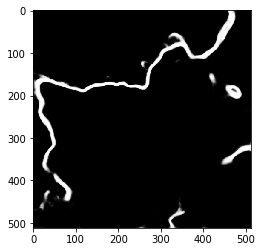

In [7]:
#-- Read an image to test
infile = os.path.join(indir,'Test_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_069_180901-180907-180913-180919_012520-023591-012695-023766_T110455_T110456_x1536_y0512_DIR11.png')
test_ind = fileList['Test'].index(infile)
f = fileList['Test'][test_ind]
im = imageio.imread(f,pilmode="L").astype(float)/255.
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

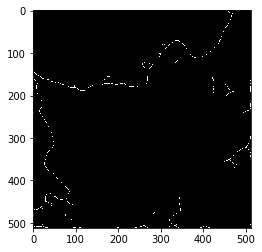

In [8]:
plt.imshow(thin(im),cmap=plt.cm.gray)
plt.show()

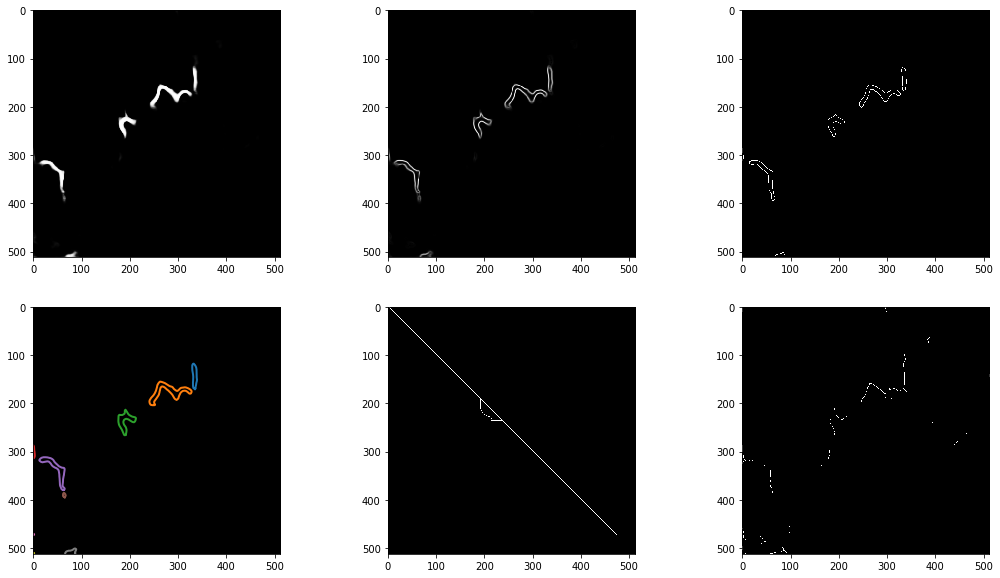

In [6]:
edge_sobel = filters.sobel(im)
edge_canny = feature.canny(im,sigma=3)
contours = measure.find_contours(im, 0.3)
# contours2 = measure.find_contours(im, 0.95)
# skeleton = skeletonize(im)
# segments_quick = quickshift(im, kernel_size=3, max_dist=2, ratio=0.5)
# segs = find_boundaries(im, connectivity=1, mode='thick', background=0)
segs = felzenszwalb(im)

fig,ax = plt.subplots(2,3,figsize=(18,10))
ax[0,0].imshow(im, cmap=plt.cm.gray)
ax[0,1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[0,2].imshow(edge_canny, cmap=plt.cm.gray)
im_test = np.zeros(im.shape)
ax[1,0].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
for n, contour in enumerate(contours):
    ax[1,0].plot(contour[:, 1], contour[:, 0], linewidth=2)
    #-- draw line through contour
    #-- first make image with just 1 contour, and invert weights
    cc = np.rint(contour).astype(int)
    im2 = np.ones(im.shape,dtype=int)
    im2[cc[:,0],cc[:,1]] = 0
    startPoint = (cc[0][-1],cc[1][-1])
    endPoint = (cc[0][0],cc[1][0])
    testIndices, testWeight = route_through_array(im2, (startPoint[0], startPoint[1]),
                        (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)
    testIndices = np.array(testIndices)
    im_test[testIndices[:,0],testIndices[:,1]] = 1
ax[1,1].imshow(im_test, cmap=plt.cm.gray)
ax[1,2].imshow(thin(im), cmap=plt.cm.gray)
plt.show()

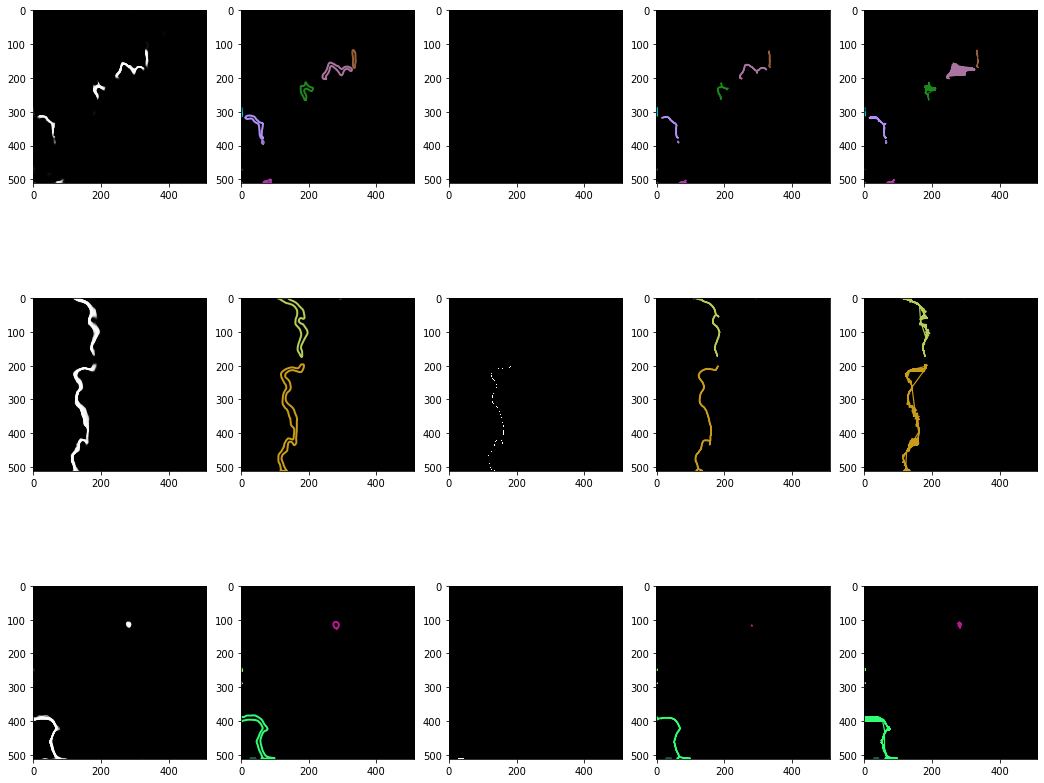

In [35]:
fig,ax = plt.subplots(3,5,figsize=(18,15))
eps = 0.3
attributes = {"id": 1, "name": "polygon", "valid": True}
for j,k in enumerate([15,20,30]):
    im = imageio.imread(fileList[k]).astype(float)/255.
    
    #-- close contour ends to make polygons
    im[np.nonzero(im[:,0] > eps),0] = eps
    im[np.nonzero(im[:,-1] > eps),-1] = eps
    im[0,np.nonzero(im[0,:] > eps)] = eps
    im[-1,np.nonzero(im[-1,:] > eps)] = eps

    contours = measure.find_contours(im, eps)
    
#     im2 = np.zeros(im.shape, dtype=int)
    ax[j,1].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    ax[j,3].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    ax[j,4].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    for n, contour in enumerate(contours):
        col = np.random.rand(3,)
        ax[j,1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=col)
        #-- draw line through contour
        #-- first make image with just 1 contour, and invert weights
        im2 = np.zeros(im.shape, dtype=int)
        im2[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        im2 = skeletonize(ndimage.binary_fill_holes(im2))

        #-- plot contours from thinned lines
        thin_contours = measure.find_contours(im2, .99)
#         xc,yc = [],[]
        for c in thin_contours:
            ax[j,3].plot(c[:,1],c[:,0], linewidth=1.5, color=col)
#             xc.extend(c[:,1])
#             yc.extend(c[:,0])
#         ax[j,3].plot(xc,yc, linewidth=2, color=col)
        
        #-- use centerline module
        p = Polygon(zip(contour[:, 1], contour[:, 0]))
        centerline = Centerline(p, **attributes)
        xc,yc = [],[]
        for w in range(len(centerline.geoms)):
            xtmp,ytmp = centerline.geoms[w].coords.xy
            xc.extend(xtmp)
            yc.extend(ytmp)
        ax[j,4].plot(xc,yc,linewidth=1.2,color=col)
            
            
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,2].imshow(im2, cmap=plt.cm.gray)
plt.show()

In [36]:
attributes = {"id": 1, "name": "polygon", "valid": True}
p = Polygon(zip(np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')))
centerline = Centerline(p, **attributes)
centerline.geoms

In [34]:
x,y = centerline.geoms[0].coords.xy
y

array('d', [110.82552568329791, 111.41976323029994])

In [74]:
cs = np.argwhere(im >= 0.5)
kdt = cKDTree(cs)
edges = kdt.query_pairs(1)
ed = np.array(list(edges))

In [81]:
ed[0]

array([3017, 3067])

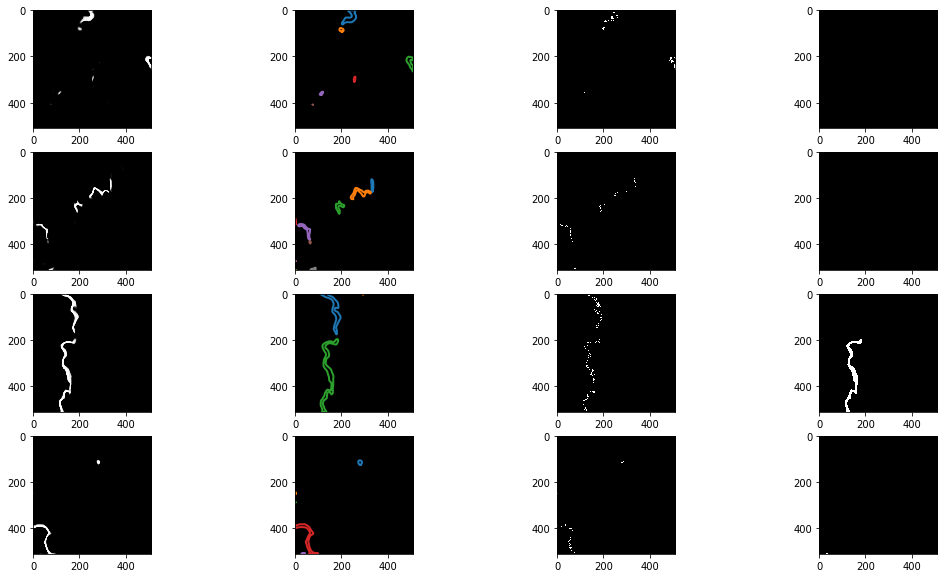

In [39]:
inds = [10,15,20,30]
fig,ax = plt.subplots(4,4,figsize=(18,10))
for j,i in enumerate(inds):
    f = fileList[i]
    im = imageio.imread(f).astype(float)/255.  
    #-- close contour ends to make polygons
    im[np.nonzero(im[:,0] > eps),0] = eps
    im[np.nonzero(im[:,-1] > eps),-1] = eps
    im[0,np.nonzero(im[0,:] > eps)] = eps
    im[-1,np.nonzero(im[-1,:] > eps)] = eps
    contours = measure.find_contours(im, eps)
    ax[j,0].imshow(im, cmap=plt.cm.gray)
    ax[j,1].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
    im_test = np.zeros(im.shape)  
    for n, contour in enumerate(contours):
        ax[j,1].plot(contour[:, 1], contour[:, 0], linewidth=2)
        
         #-- first make image with just 1 contour, and invert weights
        im2 = np.zeros(im.shape, dtype=int)
        im2[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        im2 = ndimage.binary_fill_holes(im2)
        nl = len(contour[:,0])
        startPoint = (int(round(contour[0,0])),int(round(contour[0,1])))
        endPoint = (int(round(contour[int(nl/2),0])),int(round(contour[int(nl/2),1])))
        testIndices, testWeight = route_through_array(1-im2, (startPoint[0], startPoint[1]),
                                                      (endPoint[0], endPoint[1]), geometric=True,fully_connected=True)
        testIndices = np.array(testIndices)
        im_test[testIndices[:,0],testIndices[:,1]] = 1
    ax[j,2].imshow(im_test, cmap=plt.cm.gray)
    ax[j,3].imshow(im2, cmap=plt.cm.gray)
plt.show()

In [33]:
fileList['Train']

['/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180921-180927-180927-181003_012808-023879-023879-012983_T050840_T050926_x1284_y0512_DIR01.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180530-180605-180605-180611_022129-011233-011233-022304_T050919_T050834_x1382_y0137_DIR00.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180903-180909-180909-180915_023529-012633-012633-023704_T050925_T050840_x1284_y0047_DIR00.png',
 '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180816-180822-180822-180828_012283-023354-023354-012458_T050839_T050924_x1796_y1024_DIR01.png',
 '/Users/yaramohajerani/Google Drive

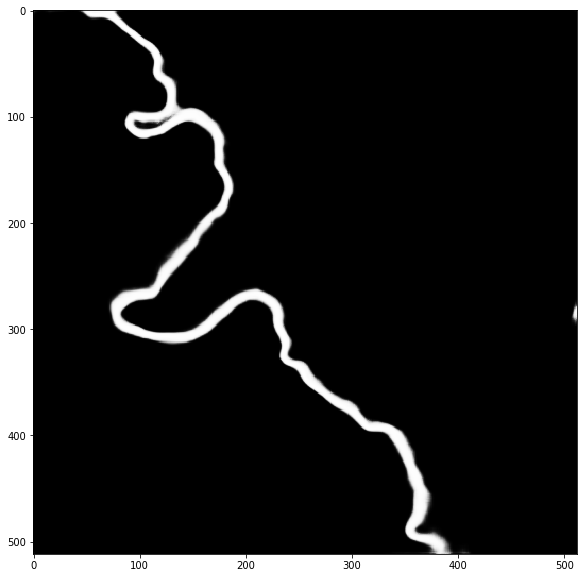

In [37]:
infile = '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_054_180328-180403-180403-180409_010230-021301-021301-010405_T102357_T102440_x1590_y1024_DIR01.png'
test_ind = fileList['Train'].index(infile)
im = imageio.imread(fileList['Train'][test_ind]).astype(float)/255.
fig = plt.figure(1,figsize=(10,10))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [50]:
eps = 0.3
#-- close contour ends to make polygons
im[np.nonzero(im[:,0] > eps),0] = eps
im[np.nonzero(im[:,-1] > eps),-1] = eps
im[0,np.nonzero(im[0,:] > eps)] = eps
im[-1,np.nonzero(im[-1,:] > eps)] = eps
#- get contours
contours = measure.find_contours(im, eps)
#-- make contours into closed polyons to find pinning points
pols = [None]*len(contours)
for n, contour in enumerate(contours):
    pols[n] = Polygon(zip(contour[:,0],contour[:,1]))
#-- intialize matrix of polygon containment
cmat = np.zeros((len(pols),len(pols)),dtype=bool)
for i in range(len(pols)):
    for j in range(len(pols)):
        if (i != j) and pols[i].contains(pols[j]):
            #-- if the outer contour is significantly longer than the
            #-- inner contour, then it's not a pinning point but a loop
            #-- in the GL (use factor of 10 difference). In that case, get 
            #-- the inner loop instead
            if len(contours[i][:,0]) > 10*len(contours[j][:,0]):
                cmat[j,i] = True
            else:
                cmat[i,j] = True
            
cmat

array([[False, False, False],
       [ True, False, False],
       [False, False, False]])

In [51]:
noise = []
#-- get indices of rows with more than 1 True column in cmat
for i in range(len(cmat)):
    if np.count_nonzero(cmat[i,:]) > 1:
        noise_idx, = np.nonzero(cmat[i,:])
        #-- concentante to noise list
        noise += list(noise_idx)
        #-- turn the matrix elements back off
        for j in noise_idx:
            cmat[i,j] = False 
#-- remove repeating elements
noise = list(set(noise))

#-- go through overlapping elements and get nonoverlapping area to convert to 'donuts'
#-- NOTE we will get the the contour corresponding to the inner ring
outer = []
inner = []
for i in range(len(pols)):
    for j in range(len(pols)):
        if cmat[i,j] and (i not in noise) and (j not in noise):
            #-- save indices of inner and outer rings
            outer.append(i)
            inner.append(j)
print(noise)
print(inner)
print(outer)

[]
[0]
[1]


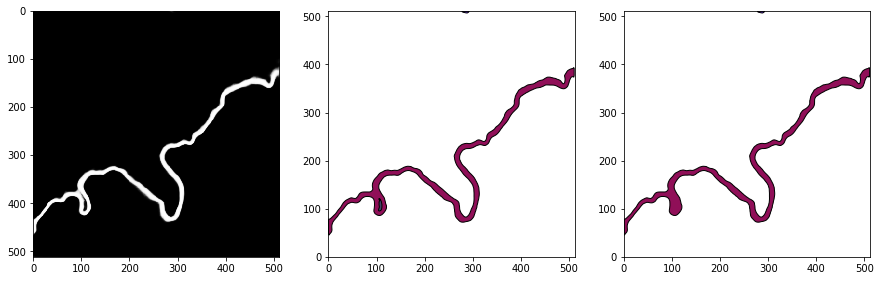

In [52]:
al = 1.0 #alpha - transparency value fro plotting
#-- plot polygons to see how one can contain 3 inside it...
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(np.flipud(im.transpose()), cmap=plt.cm.gray)
for i,p in enumerate(pols):
    r,g,b = random.random(), random.random(), random.random()
    ring_patch = PolygonPatch(p,fc=[r,g,b,al])
    ax[1].add_patch(ring_patch)
    if (i not in noise) and (i not in outer):
        ring_patch = PolygonPatch(p,fc=[r,g,b,al])
        ax[2].add_patch(ring_patch)
for i in [1,2]:
    ax[i].set_xlim([0,512])
    ax[i].set_ylim([0,512])
    ax[i].set_aspect(1)
plt.show()

In [47]:
#-- get route through array
ii = np.where(im > 0.98)
startPoint = (ii[0][-1],ii[1][-1])
endPoint = (ii[0][0],ii[1][0])

testIndices, testWeight = route_through_array(1-im, (startPoint[0], startPoint[1]),
                                              (endPoint[0], endPoint[1]))#, geometric=True,fully_connected=True)

In [48]:
testIndices = np.array(testIndices)
print(testIndices)
print(testIndices.shape)
print(im.size)

[[511 124]
 [510 124]
 [509 124]
 ...
 [  1 119]
 [  1 118]
 [  0 117]]
(583, 2)
262144


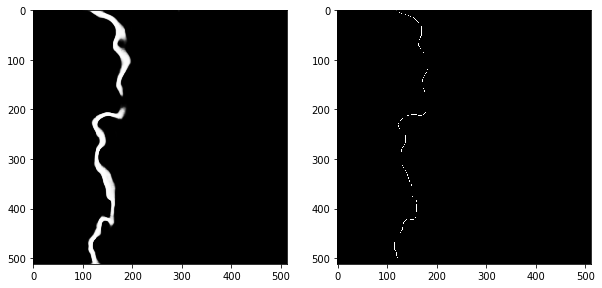

In [49]:
im_test = np.zeros(im.shape)
im_test[testIndices[:,0],testIndices[:,1]] = 1
# im_test[startPoint[0]-20:startPoint[0]+20, startPoint[1]-20:startPoint[1]+20] = 1
# im_test[endPoint[0], endPoint[1]] = 1
fig,ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].imshow(im, cmap=plt.cm.gray)
ax[1].imshow(im_test, cmap=plt.cm.gray)
plt.show()

## Run through all images and save contours

In [53]:
n_test=500
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/geocoded_v1/')
sub_tdir = {}
sub_tdir['Train'] = os.path.join(ddir,'train_n%i.dir'%n_test)
sub_tdir['Test'] = os.path.join(ddir,'test_n%i.dir'%n_test)

In [54]:
#-- Get list of images
npy_list = {}
for t in ['Train','Test']:
    tempfileList = os.listdir(sub_tdir[t])
    npy_list[t] = [f for f in tempfileList if (f.endswith('.npy') and f.startswith('coco'))]

In [55]:
%who

Centerline	 Polygon	 PolygonPatch	 al	 ax	 b	 binary_dilation	 cKDTree	 cmat	 
col	 contour	 contours	 ddir	 eps	 f	 feature	 felzenszwalb	 fig	 
fileList	 file_ind	 file_list_name	 filename	 filters	 find_boundaries	 g	 gdrive	 glob	 
i	 ignore	 im	 im2	 imageio	 img	 indir	 infile	 inner	 
ix	 iy	 j	 lbl	 measure	 n	 n_test	 ndimage	 noise	 
noise_idx	 np	 npy_list	 os	 out_subdir	 outdir	 outer	 p	 plt	 
pols	 quickshift	 r	 random	 rasterio	 ring_patch	 route_through_array	 skeletonize	 slic	 
sub_tdir	 subdir	 t	 tempfileList	 test_ind	 thin	 watershed	 


In [56]:
#-- set threshold for getting contours
eps = 0.3
for t in ['Train']: #['Train','Test']
    #-- get list of PREDICTION file names
    file_list_name = [os.path.basename(f) for f in fileList[t]]
    #-- Read images and save to file
    for i,f in enumerate(npy_list[t]):
        fig,ax = plt.subplots(2,3,figsize=(15,10))

        img = np.load(os.path.join(sub_tdir[t],f))
        lbl = binary_dilation(np.load(os.path.join(sub_tdir[t],f.replace('coco','delineation'))).reshape((img.shape[0],img.shape[1])))

        #-- find corresponding prediction file
        file_ind = file_list_name.index(f.replace('coco','pred').replace('.npy','.png'))
        im = imageio.imread(fileList[t][file_ind]).astype(float)/255.
        #-- close contour ends to make polygons
        im[np.nonzero(im[:,0] > eps),0] = eps
        im[np.nonzero(im[:,-1] > eps),-1] = eps
        im[0,np.nonzero(im[0,:] > eps)] = eps
        im[-1,np.nonzero(im[-1,:] > eps)] = eps
        #- get contours
        contours = measure.find_contours(im, eps)
        #-- make contours into closed polyons to find pinning points
        pols = [None]*len(contours)
        for n, contour in enumerate(contours):
            pols[n] = Polygon(zip(contour[:,0],contour[:,1]))
        #-- intialize matrix of polygon containment
        cmat = np.zeros((len(pols),len(pols)),dtype=bool)
        for i in range(len(pols)):
            for j in range(len(pols)):
                if (i != j) and pols[i].contains(pols[j]):
                    #-- if the outer contour is significantly longer than the
                    #-- inner contour, then it's not a pinning point but a loop
                    #-- in the GL (use factor of 10 difference). In that case, get 
                    #-- the inner loop instead
                    if len(contours[i][:,0]) > 10*len(contours[j][:,0]):
                        cmat[j,i] = True
                    else:
                        cmat[i,j] = True

        #-- However, note that if one outer control has more than 1 inner contour,
        #-- then it's not a pinning point and it's actually just noise.
        #-- In that case, ignore the inner contours. We add a new array for 'noise' points
        #-- to be ignored
        noise = []
        #-- get indices of rows with more than 1 True column in cmat
        for i in range(len(cmat)):
            if np.count_nonzero(cmat[i,:]) > 1:
                noise_idx, = np.nonzero(cmat[i,:])
                #-- concentante to noise list
                noise += list(noise_idx)
                #-- turn the matrix elements back off
                for j in noise_idx:
                    cmat[i,j] = False 
        #-- remove repeating elements
        noise = list(set(noise))

        #-- go through overlapping elements and get nonoverlapping area to convert to 'donuts'
        #-- NOTE we will get the the contour corresponding to the inner ring
        outer = []
        inner = []
        for i in range(len(pols)):
            for j in range(len(pols)):
                if cmat[i,j] and (i not in noise) and (j not in noise):
                    #-- save indices of inner and outer rings
                    outer.append(i)
                    inner.append(j)

        #-- initialize centerline plot
        im2 = np.zeros(im.shape, dtype=int)
        #--------------------------------------------------
        #-- PLOTS
        #--------------------------------------------------
        # plot image
        ax[0,0].imshow(img[:,:,0],cmap='bwr',vmin=-4,vmax=4)
        ax[0,0].set_title('Real')
        ax[0,1].imshow(img[:,:,1],cmap='bwr',vmin=-4,vmax=4)
        ax[0,1].set_title('Imag')
        # plot training label
        ax[0,2].imshow(lbl, cmap=plt.cm.gray)
        ax[0,2].set_title('Label')
        # plot prediction
        ax[1,0].imshow(im, cmap=plt.cm.gray)
        ax[1,0].set_title('Pred')
        # plot contours
        ax[1,1].imshow(np.zeros(im.shape),cmap=plt.cm.gray)
        for n, contour in enumerate(contours):
            if (n not in noise) and (n not in outer):
                col = np.random.rand(3,)
                ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=2, color=col)
                #-- draw line through contour
                im2[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
                im2 = thin(ndimage.binary_fill_holes(im2))


        ax[1,1].set_title('Post')
        ax[1,1].get_xaxis().set_ticks([])
        ax[1,1].get_yaxis().set_ticks([])

        ax[1,2].imshow(im2, cmap=plt.cm.gray)
        ax[1,2].set_title('Centerline')

        #-- remove plot axes
        for ix in range(2):
            for iy in range(3):
                ax[ix,iy].set_axis_off()
        plt.savefig(os.path.join(out_subdir[t],f.replace('coco','post').replace('.npy','.png')),format='PNG')
        plt.close()

# Experiment with gdal vectorization (06/10/2020)

In [14]:
import gdal
import ogr

In [9]:
gdal.Polygonize?

In [12]:
#-- Read an image to test
infile = os.path.join(indir,'Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_054_180328-180403-180403-180409_010230-021301-021301-010405_T102357_T102440_x1590_y1024_DIR01.png')
test_ind = fileList['Train'].index(infile)
f = fileList['Train'][test_ind]
im = imageio.imread(f).astype(float)/255.
#-- output file
outfile = os.path.join(out_subdir['Train'],f.replace('pred','post').replace('.png','.shp'))

In [16]:
utShapefile = "polygonized"
driver = ogr.GetDriverByName("ESRI Shapefile")

#-- delete exisiting file
if os.path.exists(outfile):
    driver.DeleteDataSource(outfile)
outDatasource = driver.CreateDataSource(outfile)
outLayer = outDatasource.CreateLayer("polygonized", srs=None)

newField = ogr.FieldDefn('MYFLD', ogr.OFTInteger)
outLayer.CreateField(newField)

0

In [17]:
gdal.Polygonize(im,None,outLayer, 0, [], callback=None)
outDatasource.Destroy()
sourceRaster = None

TypeError: in method 'Polygonize', argument 1 of type 'GDALRasterBandShadow *'

# Experiment with Potrace

In [15]:
import geopandas as gpd

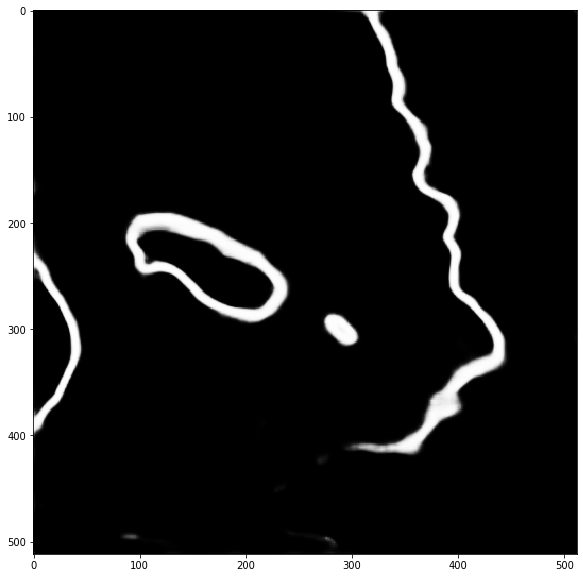

In [9]:
infile = '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.png'
test_ind = fileList['Train'].index(infile)
im = imageio.imread(fileList['Train'][test_ind]).astype(float)/255.
fig = plt.figure(1,figsize=(10,10))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

First make convert to an intermediary .pnm file

In [12]:
!convert "/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.png" "/Users/yaramohajerani/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.pnm" 

Use `potrace` to vectorize:

In [13]:
!potrace /Users/yaramohajerani/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.pnm -b geojson -o /Users/yaramohajerani/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.geojson

In [16]:
gdf = gpd.read_file('/Users/yaramohajerani/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.geojson')
gdf

,geometry
0,"POLYGON ((0 398.6, 0 375.8, 0.1 354.5, 0.1 335..."
1,"POLYGON ((102.6 300.7, 100.9 299, 99.599999999..."
2,"POLYGON ((-0 199.6, 0 176.8, 0 159.7, 0.1 147...."


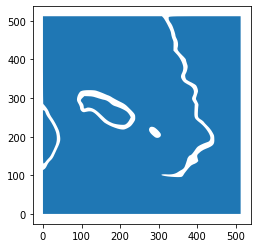

In [17]:
gdf.plot()

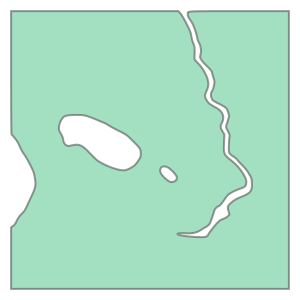

In [22]:
gdf['geometry'][0]

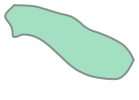

In [23]:
gdf['geometry'][1]

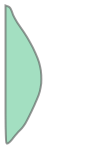

In [24]:
gdf['geometry'][2]

# Experiment wiht centerline

In [8]:
from centerline.geometry import Centerline

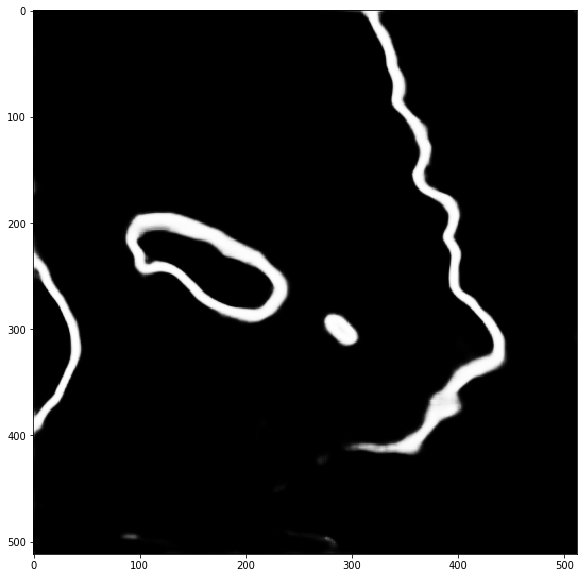

In [9]:
infile = '/Users/yaramohajerani/Google Drive File Stream/My Drive/GL_Learning/Train_predictions.dir/atrous_32init_drop0.2_customLossR727.dir/pred_gl_007_180424-180430-180430-180506_021604-010708-010708-021779_T050918_T050832_x1930_y1024_DIR01.png'
test_ind = fileList['Train'].index(infile)
im = imageio.imread(fileList['Train'][test_ind]).astype(float)/255.
fig = plt.figure(1,figsize=(10,10))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [10]:
#-- First, we polygonize
eps = 0.3 # contour threshold
#-- close contour ends to make polygons
im[np.nonzero(im[:,0] > eps),0] = eps
im[np.nonzero(im[:,-1] > eps),-1] = eps
im[0,np.nonzero(im[0,:] > eps)] = eps
im[-1,np.nonzero(im[-1,:] > eps)] = eps
#- get contours
contours = measure.find_contours(im, eps)
#-- make contours into closed polyons to find pinning points
pols = [None]*len(contours)
for n, contour in enumerate(contours):
    pols[n] = Polygon(zip(contour[:,0],contour[:,1]))

In [11]:
pols[1].contains(pols[2])

True

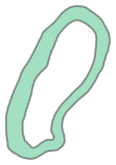

In [12]:
pols[1].difference(pols[2])

In [13]:
pp = pols[1].difference(pols[2])

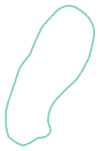

In [14]:
attributes = {"id": 0, "name": "polygon", "valid": False}
cl = Centerline(pp,interpolation_distance=5, **attributes)
cl

In [16]:
!pip install pySkeleton

In [18]:
from pySkeleton import polygon

ModuleNotFoundError: No module named 'pySkeleton'

In [225]:
len(cl)

145

In [226]:
cl.length

363.7828423200805

In [229]:
cl.geom_type

'MultiLineString'

In [111]:
from shapely.geometry import MultiLineString,LineString

In [57]:
l = MultiLineString(cl)

In [58]:
type(l)

shapely.geometry.multilinestring.MultiLineString

In [70]:
xy = []
for i in range(len(cl)):
    xy.extend(cl[i].coords.xy)

In [75]:
from shapely import ops

In [76]:
merged_line = ops.linemerge(cl)

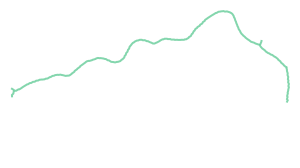

In [77]:
merged_line

In [80]:
len(merged_line), len(cl)

(7, 227)

In [84]:
#-- get longest line and plot
np.argmax([m.length for m in merged_line])

2

In [86]:
ll = merged_line[2]

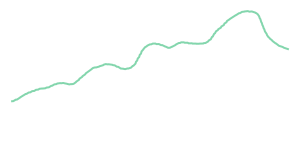

In [87]:
ll

In [90]:
x,y = ll.coords.xy

In [92]:
len(x),len(y)

(174, 174)

In [94]:
cn = [list(a) for a in zip(x,y)]

In [96]:
len(cn)

174

In [4]:
#-- directory setup
ddir = os.path.expanduser('~/GL_learning_data/geocoded_v1')
subdir = 'atrous_32init_drop0.2_customLossR727.dir'
FILTER = 6000
pred_dir = os.path.join(ddir,'stitched.dir',subdir)
pred_file = 'gl_069_181218-181224-181224-181230_014095-025166-025166-014270_T110614_T110655.tif'

In [5]:
#-- threshold for getting contours and centerlines
eps = 0.3
#-- read file
raster = rasterio.open(os.path.join(pred_dir,pred_file),'r')
im = raster.read(1)
#-- get transformation matrix
trans = raster.transform

In [6]:
bb = raster.bounds
bb

BoundingBox(left=-1122750.0, bottom=-1301750.0, right=-917950.0, top=-1013750.0)

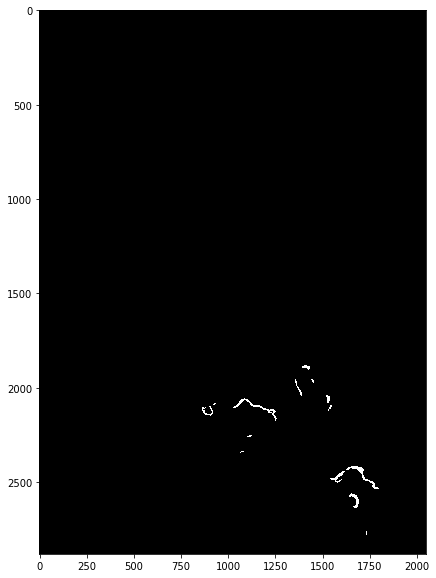

In [7]:
fig = plt.figure(1,figsize=(10,10))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

In [8]:
#-- get contours of prediction
#-- close contour ends to make polygons
im[np.nonzero(im[:,0] > eps),0] = eps
im[np.nonzero(im[:,-1] > eps),-1] = eps
im[0,np.nonzero(im[0,:] > eps)] = eps
im[-1,np.nonzero(im[-1,:] > eps)] = eps
contours = measure.find_contours(im, eps)

In [9]:
#-- make contours into closed polyons to find pinning points
#-- also apply noise filter and append to noise list
x = {}
y = {}
noise = []
pols = [None]*len(contours)
pol_type = [None]*len(contours)
for n,contour in enumerate(contours):
    #-- convert to coordinates
    x[n],y[n] = rasterio.transform.xy(trans, contour[:,0], contour[:,1])
    pols[n] = Polygon(zip(x[n],y[n]))

In [10]:
len(pols)

18

In [11]:
ignore_list = []
for i in range(len(pols)):
    for j in range(len(pols)):
        if (i != j) and pols[i].contains(pols[j]):
            pols[i] = pols[i].difference(pols[j])
            ignore_list.append(j)

In [12]:
ignore_list

[10]

In [ ]:
%matplotlib widget

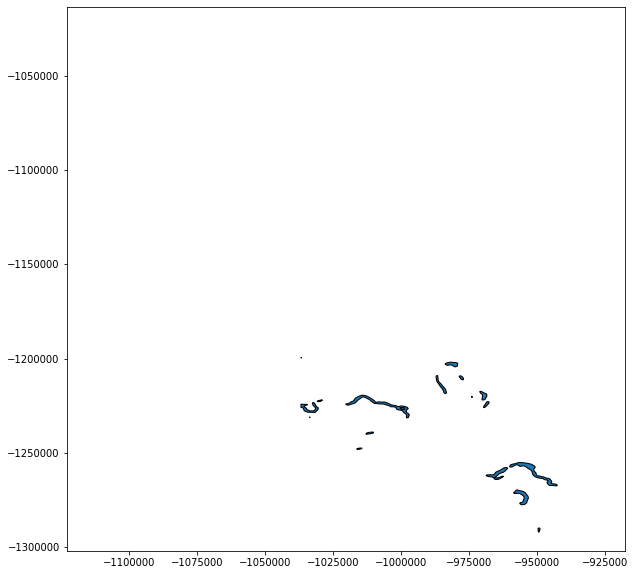

In [13]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111)
for i,p in enumerate(pols):
    ring_patch = PolygonPatch(p)
    ax.add_patch(ring_patch)

ax.set_xlim([bb[0],bb[2]])
ax.set_ylim([bb[1],bb[3]])
plt.show()

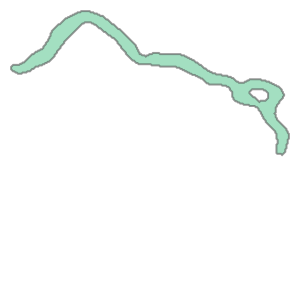

In [25]:
pols[5]

In [26]:
idx = 5

In [27]:
dis = pols[idx].length/100

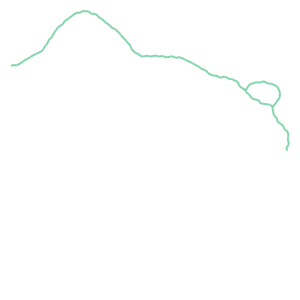

In [28]:
#-- get centerlines
attributes = {"id": pols[idx], "name": "polygon", "valid": True}
cl = Centerline(pols[idx],interpolation_distance=dis, **attributes)
cl

In [29]:
cl.geom_type

'MultiLineString'

In [32]:
#-- get longest line and plot
merged_lines = linemerge(cl)
line_ind = np.argmax([m.length for m in merged_lines])
xc,yc = merged_lines[line_ind].coords.xy

In [33]:
len(cl),len(merged_lines)

(101, 4)

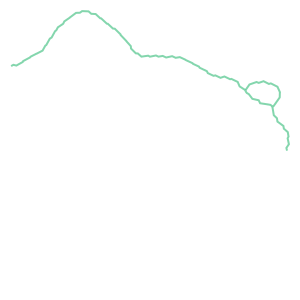

In [34]:
merged_lines

In [35]:
merged_lines[line_ind].length

23328.105315476925

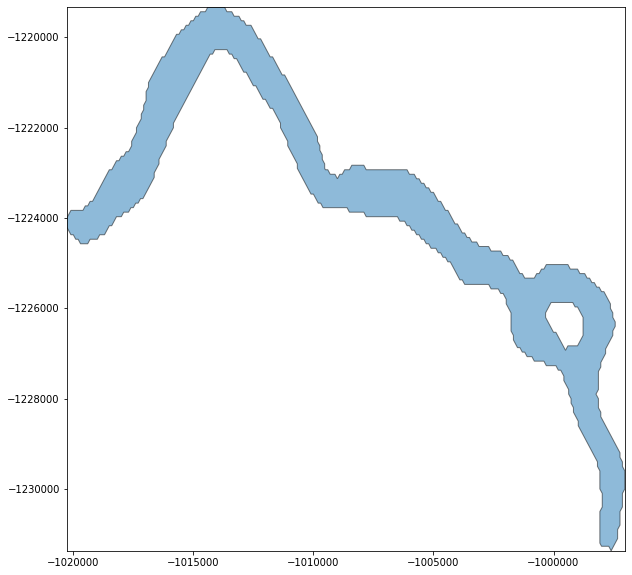

In [38]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111)
ring_patch = PolygonPatch(pols[idx],alpha=0.5)
ax.add_patch(ring_patch)
plt.plot(yc,xc,'r-',linewidth=1.5)

ext_x,ext_y = pols[idx].exterior.coords.xy

ax.set_xlim([np.min(ext_x),np.max(np.max(ext_x))])
ax.set_ylim([np.min(ext_y),np.max(np.max(ext_y))])
plt.show()